In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import scaling_lib.ftutils_torch as ftutils
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
from scaling_lib.split_step_solver import BPMSplitStepSolver
from scaling_lib.waveguide import Waveguide
from scaling_lib.helpers import smoothen2d, gaussian_beam, make_HG_modes, timestring, L2, has_converged
from scaling_lib.pat import make_pat_func
from scaling_lib import pnn_utils 

# Parameters

In [3]:
Nmodes = 2

# waveguide parameters
λ0 = 1.55 # free-space wavelength, all lengths are in um
k0 = 2*np.pi/λ0
neff = 1.8 # effective index of slab mode

# x-axis
Lx = 500 # width of simulation area (transverse dimension)
Nx = 2**9 # number of pixels in transverse dimensions
dx = Lx/(Nx-1) # stepsize in transverse dimension
x_axis = ftutils.ft_t_axis(Nx, dx)

# z-axis
dz = 50 # propagation step in z-direction
Lz = 10000 # length of device in propagation-direction
Nz = int(np.floor(Lz/dz))
z_axis = (torch.arange(Nz)+1)*dz

# mode properties
mode_x_min = -50 # center position of leftmost mode
mode_x_max = 50 # center position of rightmost mode
w0 = 20 # standard deviation of gaussian mode

# training parameters
delta_n_val = 1e-3 # maximal refractive index change
seed = 1 # seed used when sampling random unitary
iterations = 100 # number of training epochs
lr = 0.5e-1 # learning rate
gamma = 0.99
batch_size = Nmodes
device = "cuda" if torch.cuda.is_available() else "cpu"

# The waveguide class is just a convenient way of storing all parameters associated with the waveguide
# It doesn't do anything beyond that
wg = Waveguide(neff, x_axis, z_axis, device=device)

## Define input and output modes

In [4]:
# We use Gaussian beams as our "modes"
input_modes = torch.vstack([gaussian_beam(x_axis, mu, w0) for mu in np.linspace(mode_x_min, mode_x_max, Nmodes)])
output_modes = make_HG_modes(x_axis, x_center=0, w0 = w0, n = 2)

C:\Users\marti\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:5484: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[1:N+1, 1] = dep1slice
C:\Users\marti\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\marti\anaconda3\Lib\site-packages\torch\_tensor.py:1151: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


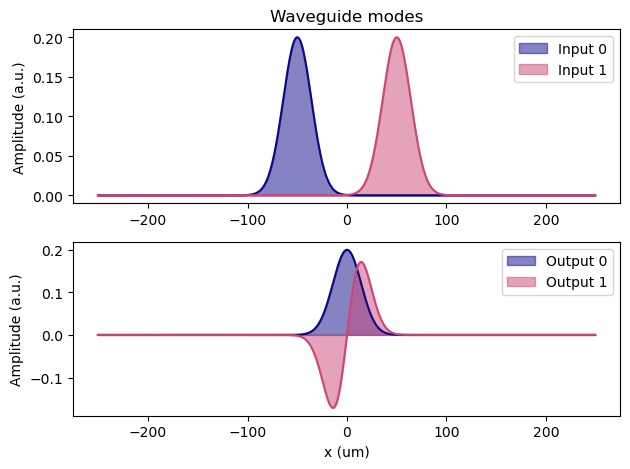

In [5]:
plt.subplot(2,1,1)
for ind_mode, mode in enumerate(input_modes):
    plt.fill_between(x_axis, mode, label = f'Input {ind_mode}', color = cm.plasma(ind_mode/(Nmodes)), alpha = 0.5)
    plt.plot(x_axis, mode, color = cm.plasma(ind_mode/(Nmodes)))

plt.legend(loc = 'upper right')
plt.title('Waveguide modes')
plt.ylabel('Amplitude (a.u.)')

plt.subplot(2,1,2)
for ind_mode, mode in enumerate(output_modes):
    plt.fill_between(x_axis, mode, label = f'Output {ind_mode}', color = cm.plasma(ind_mode/(Nmodes)), alpha = 0.5)
    plt.plot(x_axis, mode, color = cm.plasma(ind_mode/(Nmodes)))

plt.legend(loc = 'upper right')
plt.xlabel('x (um)')
plt.ylabel('Amplitude (a.u.)')

plt.tight_layout()

In [6]:
# Define target unitary transformation
U_target = [[1,0], [0,1]] #unitary_group.rvs(Nmodes, random_state=seed)
U_target = torch.tensor(U_target, dtype = torch.complex64)
U_target = U_target.to(device)

## Create trainable 2D waveguide class as pytorch.nn.Module 

In [7]:
class TDwgNet(nn.Module):
    def __init__(self, solver, wg, delta_n_val, input_modes, output_modes, device, res_x = 1, res_z =1):
        super(TDwgNet, self).__init__()
        self.device = device
        
        mod = 0.5*torch.ones([wg.Nz, wg.Nx], requires_grad=True, dtype=torch.float32).to(self.device)
        self.mod = pnn_utils.Parameter(mod, limits=[0.05, 0.95]) 
        self.delta_n_val = delta_n_val
        self.scale_x = res_x # resolution limit in x-direction
        self.scale_z = res_z # resolution limit in z-direction
        
        self.input_modes = input_modes.to(dtype=torch.complex64).to(self.device)
        self.output_modes = output_modes.to(dtype=torch.complex64).to(self.device)
        
        self.wg = wg
        self.solver = solver

    def forward(self, x, monitor = False):
        mod = self.mod
        mod = mod.clip(0., 1.)
        mod = smoothen2d(self.wg.x_axis, self.wg.z_axis, mod, scale_x = self.scale_x, scale_z = self.scale_z)

        inputs = x.to(self.device) @ self.input_modes
        
        delta_n = self.wg.background_delta_n + self.delta_n_val*mod
        output_beams = self.solver.run_simulation(inputs, delta_n, monitor)
        
        a_out = output_beams@self.output_modes.T*dx
        return a_out

## Training loop

In [8]:
bpmsolver = BPMSplitStepSolver(x_axis, z_axis, neff)
tdwg_pnn = TDwgNet(bpmsolver, wg, delta_n_val, input_modes, output_modes, device)
optimizer = optim.Adam(tdwg_pnn.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
tdwg_pnn.train()

TDwgNet()

In [9]:
print_interval = 10

loss_list = []
n = len(tdwg_pnn.input_modes)  # length of the original vector
indices = np.arange(n)
batch_indices = np.array_split(indices, np.ceil(n / batch_size))  # Split into subvectors

for i in range(iterations):
    optimizer.zero_grad()

    for indices in batch_indices:
        U_num = tdwg_pnn.forward(torch.eye(n, dtype = torch.complex64)[indices])
        l_objective = L2(U_target[indices], U_num)

        l_lagrange = pnn_utils.lagrangian(tdwg_pnn, lag_amp = 1, factor = 20)
        l = l_objective + l_lagrange 
        # l = l_objective
        l.backward()
        
    optimizer.step()
    scheduler.step()
    loss_list.append(l.detach().cpu().data)

    if i % print_interval == 0:
        print(timestring() + f"--Iteration: {i}, Loss: {l.detach().cpu().data:.5f}")
    if has_converged(loss_list):
        print(timestring() + f"Converged at iteration: {i}, Loss: {l.detach().cpu().data:.5f}")
        break

C:\Users\marti\OneDrive - Yale University\Work\Github\2D-waveguide-demo-code\scaling_lib\split_step_solver.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dz = torch.tensor(self.dz, device=device, dtype=delta_n.dtype)


2025-09-23--11-21-49--Iteration: 0, Loss: 0.49991
2025-09-23--11-21-50--Iteration: 10, Loss: 0.05083
2025-09-23--11-21-51--Iteration: 20, Loss: 0.02134
2025-09-23--11-21-52--Iteration: 30, Loss: 0.00445
2025-09-23--11-21-53--Iteration: 40, Loss: 0.00353
2025-09-23--11-21-54--Iteration: 50, Loss: 0.00133
2025-09-23--11-21-55--Iteration: 60, Loss: 0.00091
2025-09-23--11-21-56--Iteration: 70, Loss: 0.00060
2025-09-23--11-21-57--Iteration: 80, Loss: 0.00048
2025-09-23--11-21-58--Iteration: 90, Loss: 0.00043


Text(0, 0.5, 'Loss')

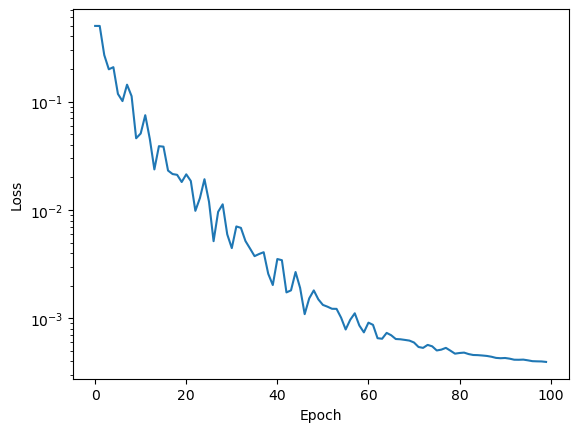

In [10]:
plt.plot(loss_list)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [11]:
# perform a forward-pass with monitor = True to visualize internal optical fields
with torch.no_grad():
    U_num_inv = tdwg_pnn.forward(torch.eye(Nmodes, dtype = torch.complex64), monitor = True)

avg_error_inv = torch.mean(torch.abs(U_num_inv-U_target))/torch.mean(torch.abs(U_target)) * 100
print(f"Average error for inverse design: {avg_error_inv:.2f}%")

Average error for inverse design: 1.90%


## Plot results

In [12]:
def plot_delta_n(z_axis, x_axis, delta_n, vmax):
    figsize_deltan = (2*3, 2*1.5*3/5)
    fig_main, ax = plt.subplots(figsize=figsize_deltan, dpi=200)
    img = plt.pcolormesh(z_axis/1000, x_axis, np.real(delta_n.T), cmap="Greens", vmax=vmax, vmin=0)
    plt.ylim(x_axis.min(), x_axis.max())
    plt.xlabel("z (mm)")
    plt.ylabel("x (um)")
    plt.title(r"$\Delta n(x, z)$")
    plt.colorbar()

    plt.show()

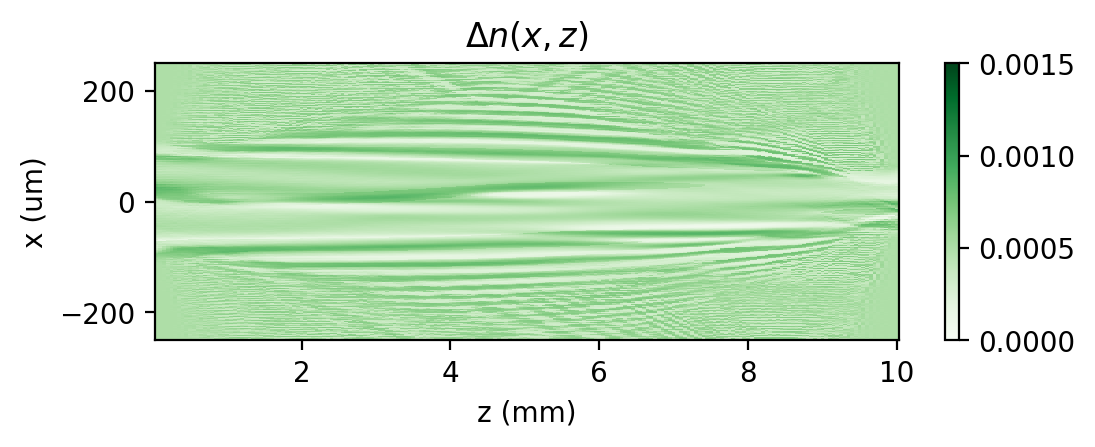

In [13]:
delta_n_inv = delta_n_val*(torch.clip(tdwg_pnn.mod.detach().cpu(), 0., 1.))
plot_delta_n(wg.z_axis, wg.x_axis, delta_n_inv, 1.5*delta_n_val)

In [14]:
def plot_intensity(z_axis, x_axis, Imat_x):
    figsize_deltan = (2*3, 2*1.5*3/5)
    fig_main, ax = plt.subplots(figsize=figsize_deltan, dpi=200)
    img = plt.pcolormesh(z_axis/1000, x_axis, Imat_x, cmap="Reds")
    plt.ylim(x_axis.min(), x_axis.max())
    plt.xlabel("z (mm)")
    plt.ylabel("x (um)")
    plt.title(r"$I(x, z)$")
    plt.colorbar()

    plt.show()

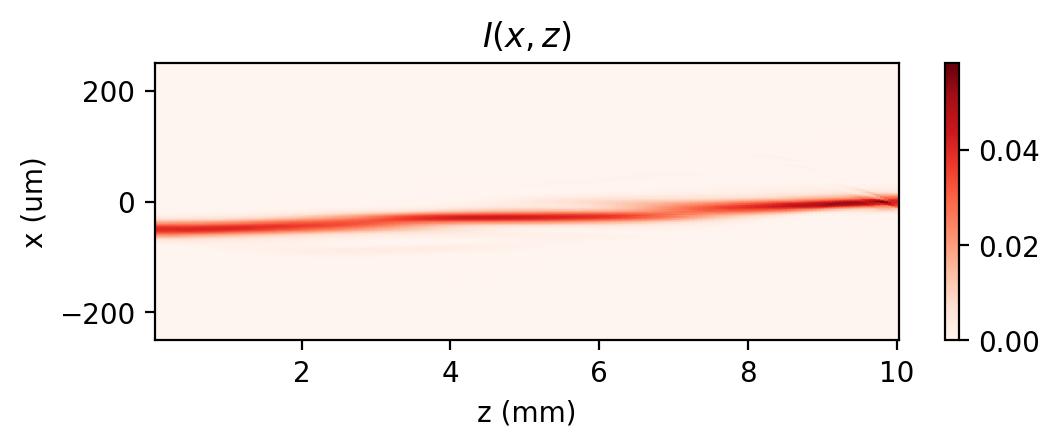

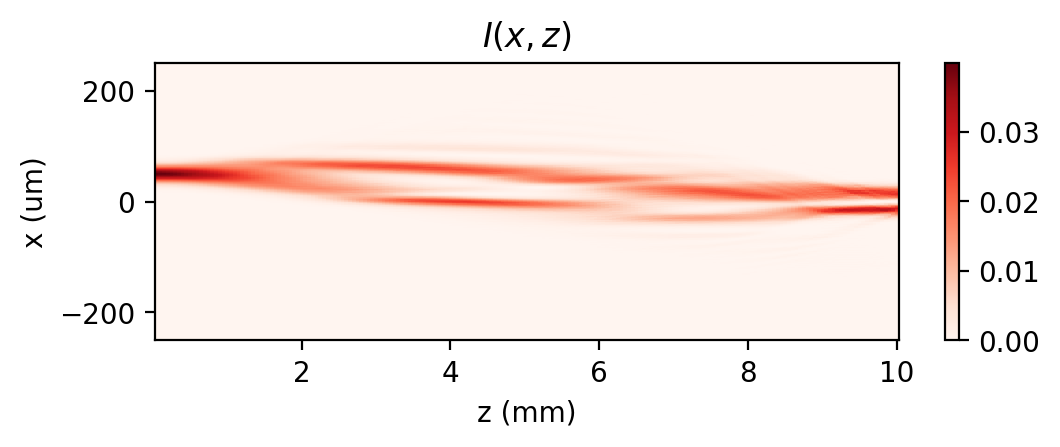

In [15]:
ind =  0
Emat_x = tdwg_pnn.solver.Emat_x[:,ind].cpu().detach()
Imat_x = Emat_x.abs().square()
z_list = z_axis[::tdwg_pnn.solver.Ncom]
plot_intensity(z_list, x_axis, Imat_x.T)

ind =  1
Emat_x = tdwg_pnn.solver.Emat_x[:,ind].cpu().detach()
Imat_x = Emat_x.abs().square()
z_list = z_axis[::tdwg_pnn.solver.Ncom]
plot_intensity(z_list, x_axis, Imat_x.T)